# 3D Point Cloud Clustering with K-means and Python

Inside this notebook we will use K-Means clustering asecond time in order to seperate more points from the <i>not ground</i> class into the right class<br>
The main sourc of the clustering part is <a href=https://towardsdatascience.com/3d-point-cloud-clustering-tutorial-with-k-means-and-python-c870089f3af8>Florent Poux (2022): 3D Point Cloud Clusterin Tutorial with K-means and Python, Toward DataSciene</a>

<b>This Jupyter-Notebook is part of a master thesis with the topic<br>
<i>Analysis of deep learning methods for semantic segmentation of photogrammetric point clouds from aerial images</i><br>
&copy; Markus Hülsen, Matr.-Nr. 6026370<br>
Date: 15.08.2023</b>

## Setting up 3D Python Context
Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import laspy
import os
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.preprocessing import MinMaxScaler

## Import Data
Data is stored as `LAS`-file. We will use `laspy` to import und convert the data.<br>
First we create a function to import an `LAS`-File and convert them into a Pandas `DataFrame`.

In [2]:
def import_las_to_Dataframe(path):
    with laspy.open(path) as f:
        las = f.read()
    
    # read coordinates from las
    x = np.array(las.x)
    y = np.array(las.y)
    z = np.array(las.z)

    df = pd.DataFrame({'X':x,'Y':y,'Z':z},index=np.arange(len(x)))

    for i in range(3, len(las.point_format.dimensions)):
        dim = las.point_format.dimensions[i].name
        df[dim] = np.array(las[dim])
     
    return df

Express path where the data is stored, that we want to processed. <br>All `las`-Files inside the defined folder will be stored in a list.

In [3]:
# path where the data ist stored
data_path = '../../Daten/Datensatz_H3D/'
# sub-folder which includes different acquisition dates and types like 'DIM_2016', 'DIM_2019', 'DIM_2022', 'ALS2016', ...
data = 'DIM_2022/5 - KMeans/classified'

# save files that are in laz-format
lst_files = []
for file in os.listdir(data_path + data):
    if file.endswith('.las') or file.endswith('.laz'):
        lst_files.append(data_path + data + '/' + file)

lst_files = sorted(lst_files)
print('Found', len(lst_files), 'las-files:')
print(lst_files)

Forund 12 las-files:
['../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5798000.las', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5799000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5800000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5801000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified555000_5798000.las', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified555000_5799000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified555000_5800000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified555000_5801000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified556000_5798000.laz', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified556000_5799000.las', '../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified556000_5800000.las',

Use function above to read the point cloud and convert it to pandas DataFrame.

In [4]:
# define file we want to use
las_path = lst_files[1]
las_path

'../../Daten/Datensatz_H3D/DIM_2022/5 - KMeans/classified/classified554000_5799000.laz'

In [5]:
# import data
df = import_las_to_Dataframe(las_path)

df

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,...,local_pointdensity,curvature change,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building
0,554653.83,5799259.45,71.62,9116,1,1,0,0,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,554655.05,5799260.31,70.94,9594,1,3,0,0,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,554656.96,5799260.94,70.23,17861,1,1,0,0,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,554652.90,5799259.14,71.41,8877,1,1,0,0,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,554659.95,5799262.57,69.83,18240,1,7,0,0,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096488,554985.75,5799992.13,69.41,15273,1,6,0,0,6,0,...,0.202295,0.570259,-0.944325,-4.560906,-8.890137,2.577771,NaN,0.021552,0.700000,NaN
5096489,554985.91,5799992.10,69.67,15271,1,6,0,0,6,0,...,0.206327,0.597283,-4.165963,-1.780520,0.384456,2.461305,NaN,0.008511,NaN,NaN
5096490,554985.72,5799992.19,69.59,15245,1,4,0,0,6,0,...,0.202919,0.058965,-1.217463,0.434914,0.469164,2.587353,NaN,0.004292,NaN,NaN
5096491,554984.87,5799992.19,68.55,15252,1,1,0,0,6,0,...,0.215067,0.030714,-1.144039,0.521849,0.428349,2.524421,NaN,0.004630,NaN,NaN


## Datapreparation
Some of the features are not necessary/redudant. We will remove them.

In [6]:
print('Attribute:')
for column in df:
    if len(pd.unique(df[column])) == 1:
        print(str(column) + (25 - len(str(column))) * ' '  + 'contains just a single value and will be returned!')
        df = df.drop(column, axis=1)
    else:
        print(str(column) +  (25 - len(str(column))) * ' '  + 'will be maintained')

df

Attribute:
X                        will be maintained
Y                        will be maintained
Z                        will be maintained
intensity                will be maintained
return_number            contains just a single value and will be returned!
number_of_returns        will be maintained
scan_direction_flag      contains just a single value and will be returned!
edge_of_flight_line      contains just a single value and will be returned!
classification           will be maintained
synthetic                will be maintained
key_point                contains just a single value and will be returned!
withheld                 contains just a single value and will be returned!
scan_angle_rank          contains just a single value and will be returned!
user_data                will be maintained
point_source_id          contains just a single value and will be returned!
gps_time                 contains just a single value and will be returned!
red                      will

,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,local_pointdensity,curvature change,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building
0,554653.83,5799259.45,71.62,9116,1,30,0,116,47616,47872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,554655.05,5799260.31,70.94,9594,3,30,0,113,38400,38144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,554656.96,5799260.94,70.23,17861,1,30,0,141,54272,54528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,554652.90,5799259.14,71.41,8877,1,30,0,100,40192,40704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,554659.95,5799262.57,69.83,18240,7,30,0,175,44544,46080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096488,554985.75,5799992.13,69.41,15273,6,6,0,98,58368,58112,...,0.202295,0.570259,-0.944325,-4.560906,-8.890137,2.577771,NaN,0.021552,0.700000,NaN
5096489,554985.91,5799992.10,69.67,15271,6,6,0,98,60160,59904,...,0.206327,0.597283,-4.165963,-1.780520,0.384456,2.461305,NaN,0.008511,NaN,NaN
5096490,554985.72,5799992.19,69.59,15245,4,6,0,94,59648,59392,...,0.202919,0.058965,-1.217463,0.434914,0.469164,2.587353,NaN,0.004292,NaN,NaN
5096491,554984.87,5799992.19,68.55,15252,1,6,0,136,55296,55040,...,0.215067,0.030714,-1.144039,0.521849,0.428349,2.524421,NaN,0.004630,NaN,NaN


## Point Cloud Filtering

### Reduce area of the Pointcloud
To reduce the number of points within the pointcloud, we will create a Bounding-Box to select a smaller areas of the pointcloud.

In [7]:
# Bounding Box
bbox_x1 = df.X.min()
bbox_y1 = df.Y.min()
bbox_x2 = (df.X.max() + df.X.min())# / 2
bbox_y2 = (df.Y.max() + df.Y.min())# / 2

# Select Point inside of Bounding Box
df_sub = df.loc[(df.X >= bbox_x1) & (df.Y >= bbox_y1) & (df.X <= bbox_x2) & (df.Y <= bbox_y2)]

print('Check Results')
print('X min:', df_sub.X.min(), 'X max:', df_sub.X.max())
print('Y min:', df_sub.Y.min(), 'Y max:', df_sub.Y.max())

df_sub

Check Results
X min: 554000.0 X max: 554999.96
Y min: 5798999.75 Y max: 5799999.74


,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,local_pointdensity,curvature change,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building
0,554653.83,5799259.45,71.62,9116,1,30,0,116,47616,47872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,554655.05,5799260.31,70.94,9594,3,30,0,113,38400,38144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,554656.96,5799260.94,70.23,17861,1,30,0,141,54272,54528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,554652.90,5799259.14,71.41,8877,1,30,0,100,40192,40704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,554659.95,5799262.57,69.83,18240,7,30,0,175,44544,46080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096488,554985.75,5799992.13,69.41,15273,6,6,0,98,58368,58112,...,0.202295,0.570259,-0.944325,-4.560906,-8.890137,2.577771,NaN,0.021552,0.700000,NaN
5096489,554985.91,5799992.10,69.67,15271,6,6,0,98,60160,59904,...,0.206327,0.597283,-4.165963,-1.780520,0.384456,2.461305,NaN,0.008511,NaN,NaN
5096490,554985.72,5799992.19,69.59,15245,4,6,0,94,59648,59392,...,0.202919,0.058965,-1.217463,0.434914,0.469164,2.587353,NaN,0.004292,NaN,NaN
5096491,554984.87,5799992.19,68.55,15252,1,6,0,136,55296,55040,...,0.215067,0.030714,-1.144039,0.521849,0.428349,2.524421,NaN,0.004630,NaN,NaN


### Just consider class `Not-Ground`
We just want to take a look on the point cloud that is classified as `Not-Ground` which is equal to `classification=13`

In [8]:
df_not_ground = df_sub.loc[df_sub.classification == 13.].drop(['classification', 'label'], axis=1, errors='ignore')
df_not_ground

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,local_pointdensity,curvature change,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,0.350056,0.019075,-4.299248,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0.0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,1.468091,0.034493,-0.687196,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0.0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,2.398698,0.541366,-0.350128,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0.0
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,1.399509,0.009347,-0.609866,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0.0
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,1.426821,0.009095,-0.696542,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,0.139580,0.474613,-1.777790,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,NaN
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,0.116434,0.423276,-1.947653,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,NaN
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,0.159113,0.407103,-1.200382,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,NaN
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,0.159926,0.077798,-0.387325,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,NaN


## Compute Geometric Features
Compution of the geometric feature of the point cloud using the some own Librarys.

In [9]:
from sklearn.neighbors import KDTree

### Define kNN with KDTree
Define the k-Nearest-Neighbors using the `KD-Tree` inside of the `sklearn` libary.<br>First we will use `K=50`

In [10]:
X = df_sub.loc[:,'X':'Z']
X

,X,Y,Z
0,554653.83,5799259.45,71.62
1,554655.05,5799260.31,70.94
2,554656.96,5799260.94,70.23
3,554652.90,5799259.14,71.41
4,554659.95,5799262.57,69.83
...,...,...,...
5096488,554985.75,5799992.13,69.41
5096489,554985.91,5799992.10,69.67
5096490,554985.72,5799992.19,69.59
5096491,554984.87,5799992.19,68.55


Convert DataFrame to Numpy Array

In [11]:
xyz = X.to_numpy()
xyz

array([[5.54653830e+05, 5.79925945e+06, 7.16200000e+01],
       [5.54655050e+05, 5.79926031e+06, 7.09400000e+01],
       [5.54656960e+05, 5.79926094e+06, 7.02300000e+01],
       ...,
       [5.54985720e+05, 5.79999219e+06, 6.95900000e+01],
       [5.54984870e+05, 5.79999219e+06, 6.85500000e+01],
       [5.54934820e+05, 5.79999114e+06, 7.06000000e+01]])

#### KD-Tree
Now let's builds a KD-Tree for faster compution and get the Nearest Neighbors.<br>
The number of neighbors `K` will be defined by `50`

In [12]:
#number of nearest neighbors
K=100

kdt = KDTree(X, leaf_size=40, metric='euclidean')
dist, indices = kdt.query(X, k=K, return_distance=True)

print('Indices:\n', indices)
print()
print('Distances:\n', dist)

Indices:
 [[      0      17      71 ...      49      23       2]
 [      1      11      63 ...      55     188      53]
 [      2      37      91 ...      68     130     151]
 ...
 [5096490 5096488 5096489 ... 5092109 4996748 4996838]
 [5096491 5041608 5041619 ... 1417215 3986664 4997008]
 [5096492  163561 5092134 ...  163308  162887  163235]]

Distances:
 [[0.         0.58335238 0.74202426 ... 3.61217386 3.65254706 3.73484939]
 [0.         0.14866069 0.59514704 ... 3.28435686 3.28677654 3.30735544]
 [0.         0.86365502 0.86821656 ... 3.30854953 3.31561457 3.31635342]
 ...
 [0.         0.19209373 0.22494444 ... 4.89493616 4.91099786 4.91627908]
 [0.         0.66105976 0.6670832  ... 4.7805962  4.7837015  4.82191871]
 [0.         0.11224972 0.35749126 ... 3.86630314 3.89249277 3.90744162]]


Now create a 3D numpy arry with for each point with class 13, with the corrisponding nearest neighbors.<br>
The Pandas function `reset_index` will change the indexes listed from `0` to `n`, so we can use the indices as positions.

In [13]:
# Estimate position of points with class = 13
pos_class13 = df_sub.reset_index().loc[df_sub.reset_index().classification == 13].index.to_numpy()

### Calculate how often the class `building`, `vegetation` and `ground` in the neighborhood occurs
First we need to calculate which labels are the neighboring labels.

In [14]:
labels = df_sub.classification.to_numpy()[indices][pos_class13]
labels

array([[13, 20, 30, ..., 30, 30, 30],
       [13, 20, 20, ..., 20, 30, 30],
       [13,  2,  2, ...,  2,  2,  2],
       ...,
       [13, 13, 13, ...,  6,  6,  6],
       [13, 13, 13, ...,  6,  6,  6],
       [13,  6, 13, ...,  6,  6,  6]], dtype=uint8)

Count how often the label `vegetation` occurs.

In [15]:
build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

Label "building" occurs [ 0  0  0 ... 46 43 82] in the neighborhoods.
50495


Count how often the label `building` occurs. 

In [16]:
veg_count = np.sum(labels == 20, axis=1)

print('Label "vegetation" occurs', veg_count, 'in the neighborhoods.')
print(len(veg_count))

Label "vegetation" occurs [ 1 25  1 ... 23 25  2] in the neighborhoods.
50495


Count how often the label `ground` occurs.

In [17]:
ground_count = np.sum(labels == 2, axis=1)

print('Label "ground" occurs', ground_count, 'in the neighborhoods.')
print(len(veg_count))

Label "ground" occurs [ 0  0 97 ...  0  0  0] in the neighborhoods.
50495


### Add results to DataFrame
Now we add the counts to our DataFrame.

In [18]:
df_features = df_not_ground
df_features['count_veg'] = veg_count
df_features['count_building'] = build_count
df_features['count_ground'] = ground_count

# Standarddeviation of Z
df_features['std_z'] = xyz[indices][pos_class13].std(1)[:,2]


df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,-4.299248,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0,1,0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,-0.687196,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0,25,0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,-0.350128,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0,1,97
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,-0.609866,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0,0,98
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,-0.696542,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0,0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,-1.777790,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,43,26,0
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,-1.947653,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,32,39,0
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,-1.200382,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,46,23,0
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,-0.387325,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,43,25,0


Drop some unnecessary features.

In [19]:
df_features = df_features.drop(['delta_z', 'scan_angle_rank'], axis=1, errors='ignore')
df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,-4.299248,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0,1,0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,-0.687196,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0,25,0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,-0.350128,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0,1,97
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,-0.609866,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0,0,98
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,-0.696542,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0,0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,-1.777790,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,43,26,0
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,-1.947653,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,32,39,0
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,-1.200382,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,46,23,0
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,-0.387325,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,43,25,0


### Save temporary

Save the results of the calculation temprary in an `csv`-file.

In [20]:
# '../Daten/Datensatz_H3D/DIM_2022/554000_5799000.las'
file = las_path.split('/')[-1].replace('.las', '').replace('.laz', '')
file

'classified554000_5799000.laz'

In [21]:
path = las_path.replace(las_path.split('/')[-1], '').replace('5 - KMeans', '6 - KMeans 2/temp').replace('classified/','')
path

'../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/temp/'

In [22]:
df_features.to_csv(path + '/temp' + file + '.csv')

### Import if already calculated
Import Features if they were already calculateted

In [23]:
is_calculate = False

if is_calculate:
    temp_path = data_path + data + '/temp/temp' + las_path.split('/')[-1].replace('.las', '') + '.csv'
    df_features = pd.read_csv(temp_path).set_index('Unnamed: 0')

df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Eigenentropy,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,-4.299248,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0,1,0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,-0.687196,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0,25,0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,-0.350128,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0,1,97
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,-0.609866,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0,0,98
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,-0.696542,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0,0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,-1.777790,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,43,26,0
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,-1.947653,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,32,39,0
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,-1.200382,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,46,23,0
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,-0.387325,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,43,25,0


### Visualize the computed features
To get a better understanding if the calculated features contain valuable information we will visualize them in some <b>histograms</b> and <b>correlation plots</b>.

In [24]:
def features_to_hist(df, cols):
    # number of attributes
    num_atts = len(df.columns)
    
    # number of rows in plot depends on number of attributes and number of columns
    if num_atts%cols == 0:
        rows = num_atts//cols
    else:
        rows = num_atts//cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=(10*cols, 6*rows))

    # counter, to estimate the position in plot
    hist_col = 0
    hist_row = 0

    for column in df:
        data = df.loc[:,column]
    
        axs[hist_row][hist_col].hist(data.to_numpy(), bins=35)
        axs[hist_row][hist_col].set_title(column)
    
        hist_col += 1
    
        if hist_col >= cols:
            hist_col = 0
            hist_row += 1

            
def visualize_correlation(df_corr, fig_size):
    # takes the Correlation-DataFrame as Input
    
    corr_array = df_corr.to_numpy()

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    im = ax.imshow(corr_array)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(df_corr.columns)))
    ax.set_xticklabels(df_corr.columns)
    ax.set_yticks(np.arange(len(df_corr.columns)))
    ax.set_yticklabels(df_corr.columns)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(df_corr.columns)):
        for j in range(len(df_corr.columns)):
            text = ax.text(j, i, round(corr_array[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title("Correlation between attributes")
    fig.tight_layout()
    plt.show()

#### Histograms of the Features

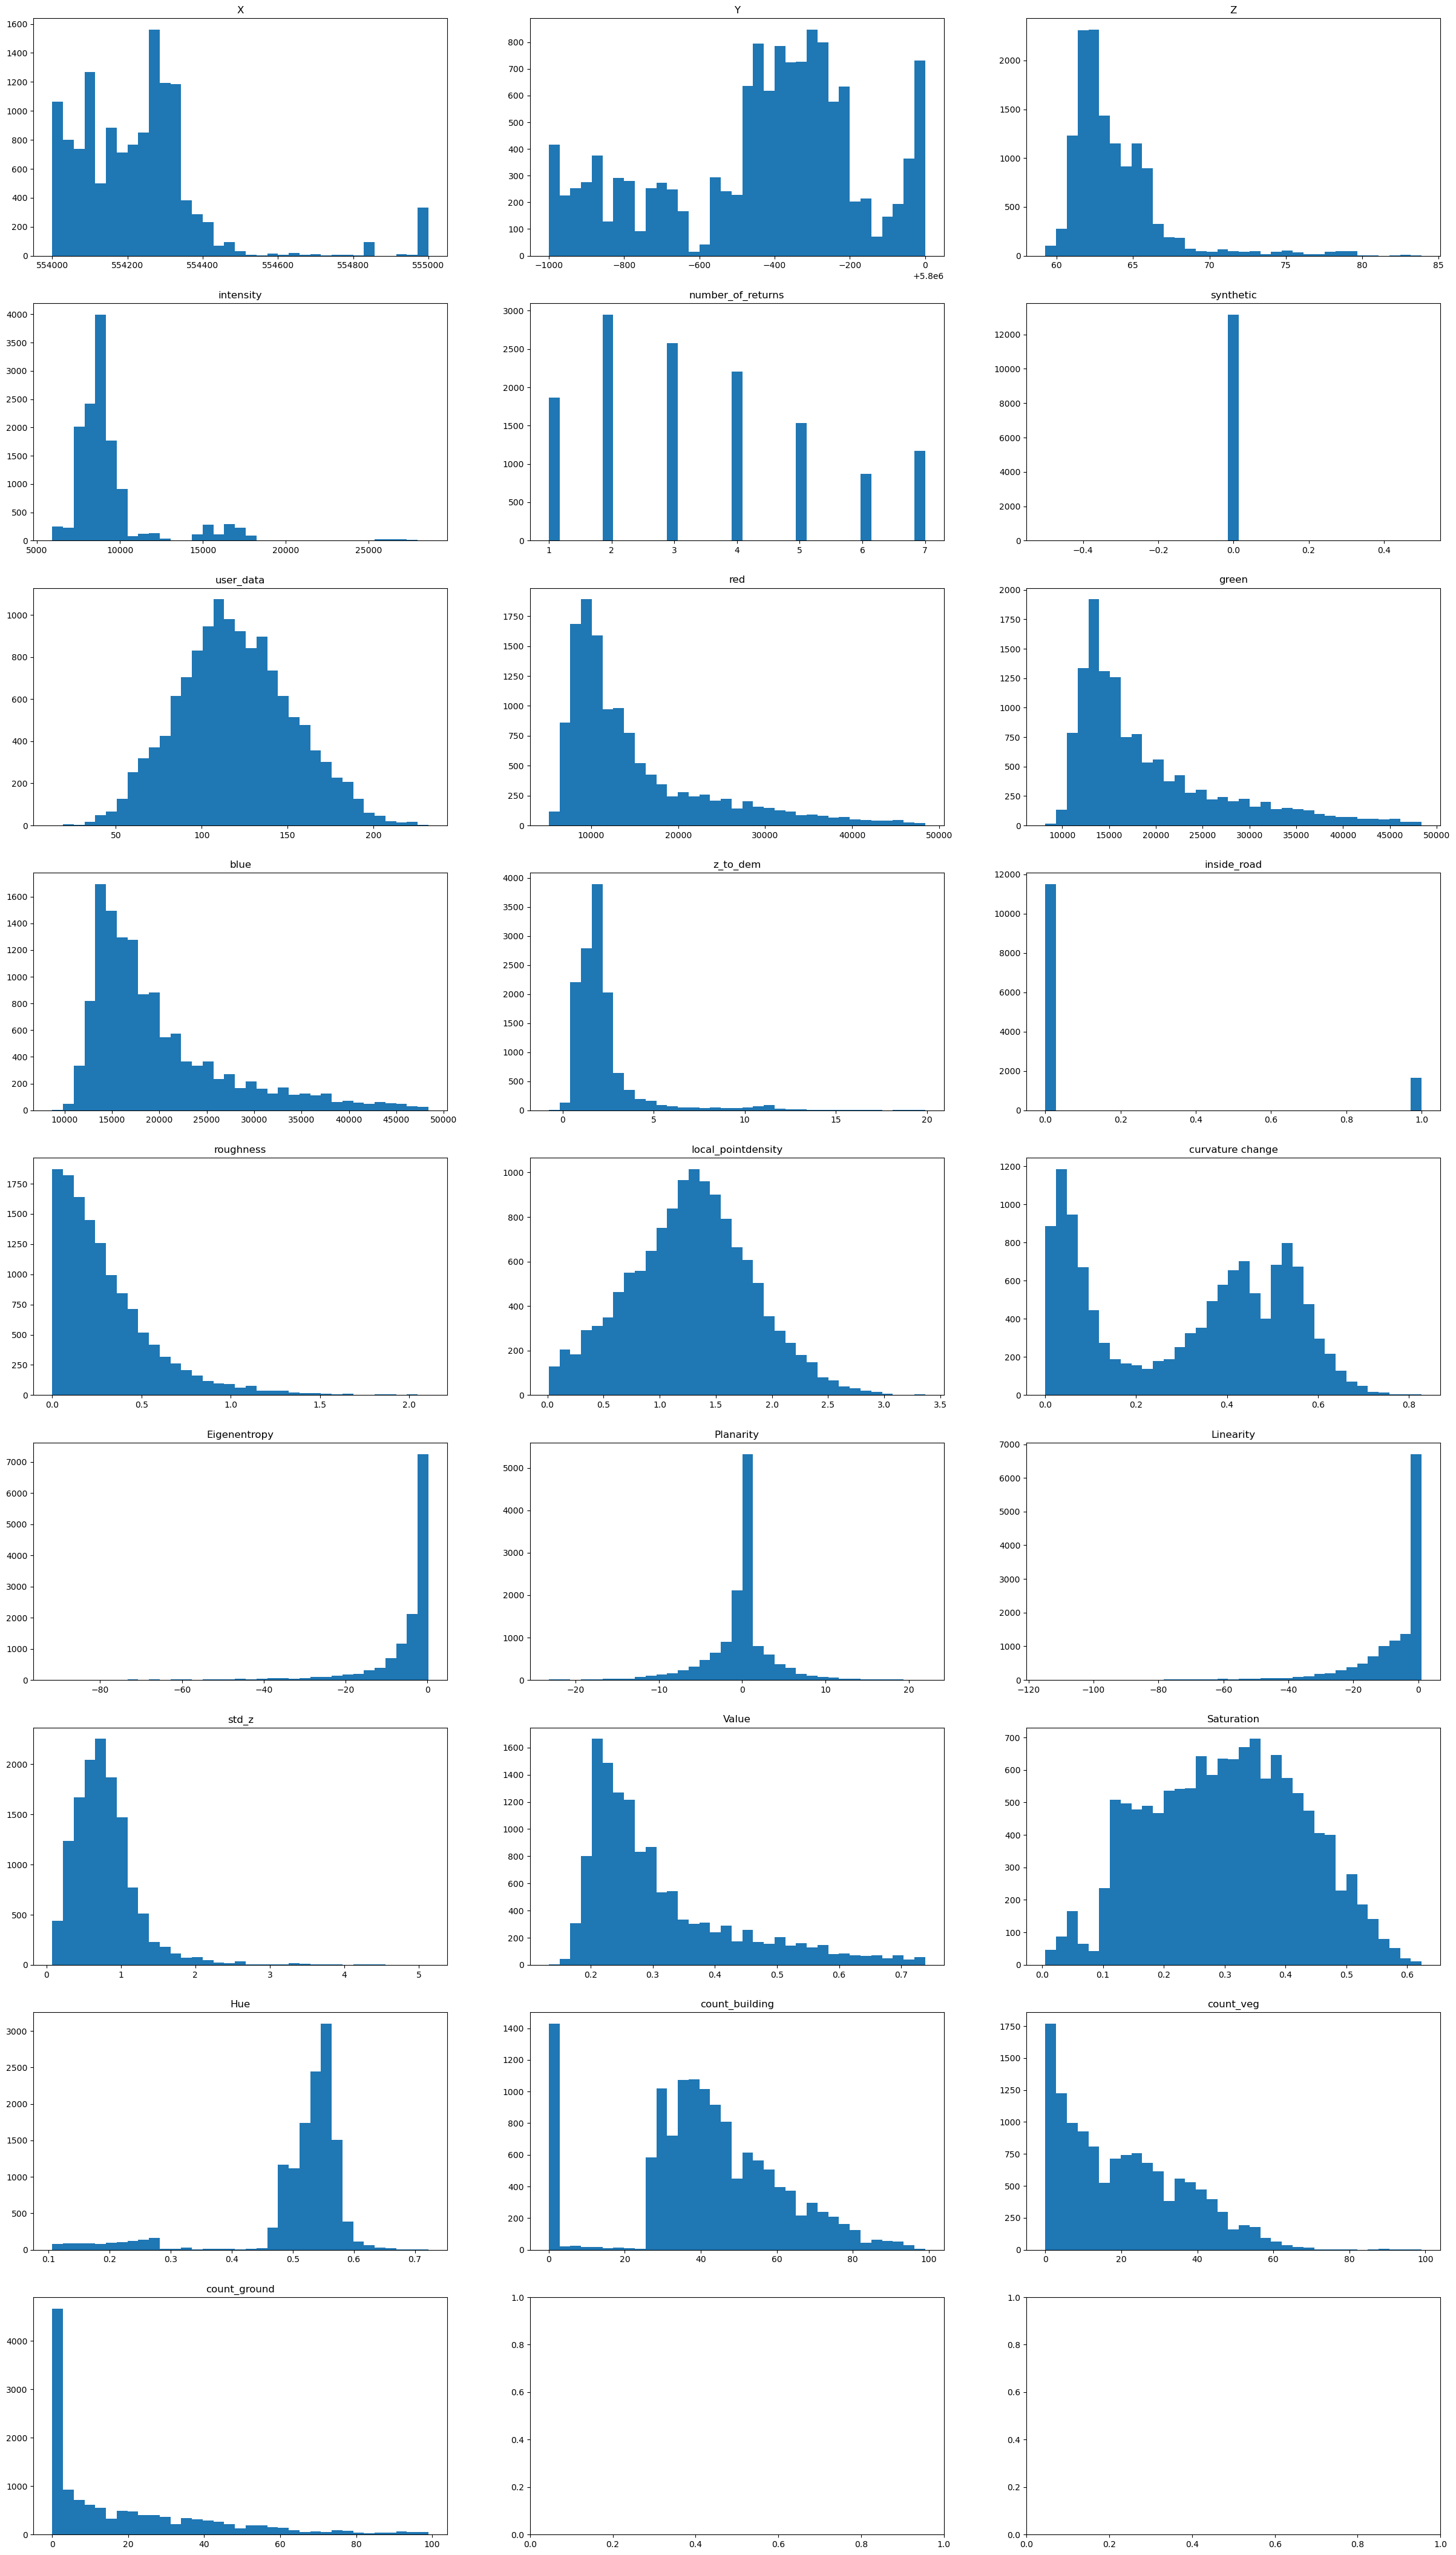

In [25]:
features_to_hist(df_features.dropna(), cols=3)

#### Correlation Plot

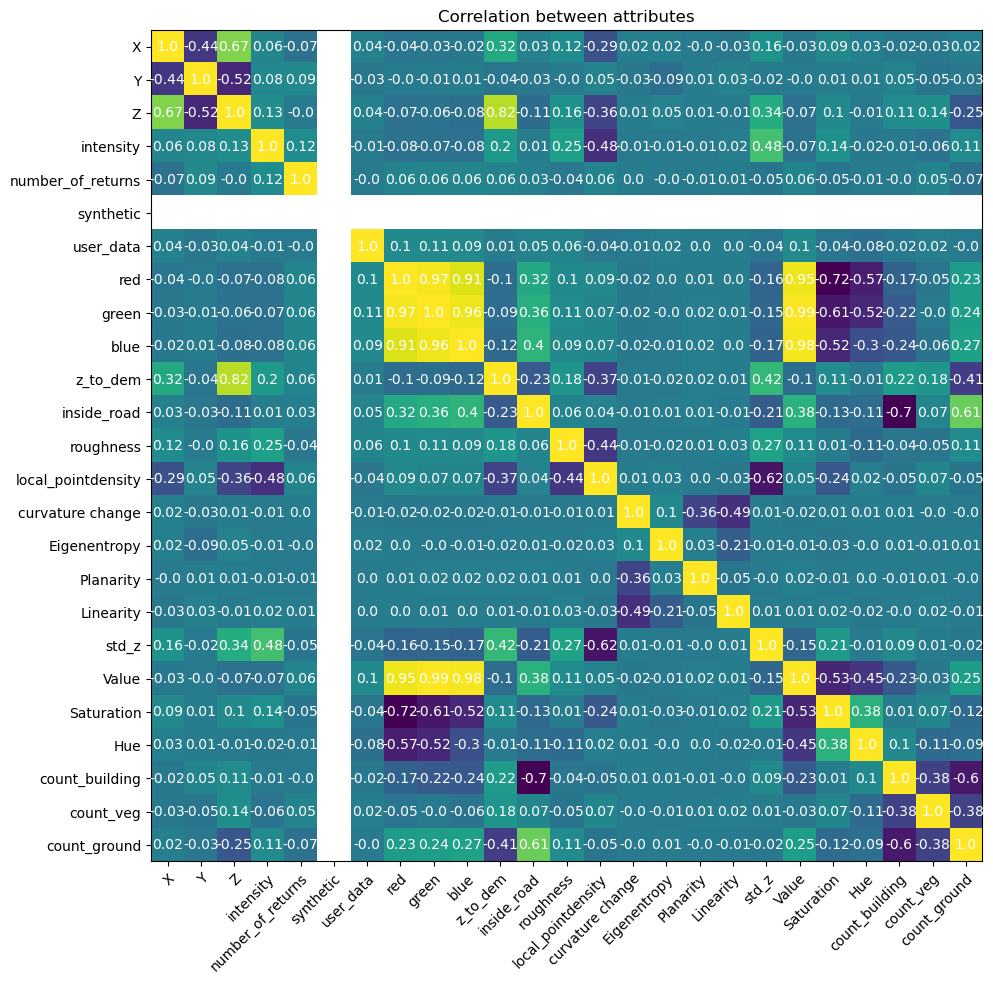

In [26]:
visualize_correlation(df_features.dropna().corr(), 10)

#### If there are NaN-Values in the HSV-colors -> Do colortransformation again

In [27]:
import colorsys

In [28]:
if df_features['Hue'].isnull().values.any() or df_features['Value'].isnull().values.any():
    print('NaN Values inside of HSV-colors!\tconvert colors again')
    r, g, b = df_features.loc[:, 'red':'blue'].to_numpy().T
    r, g ,b = (r/256).astype('uint8'), (g/256).astype('uint8'), (b/256).astype('uint8')
    rgb = np.array([r,g,b]).T
    rgb_norm = rgb/256
    hsv_norm = np.apply_along_axis(lambda x: colorsys.rgb_to_hsv(*x), -1, rgb_norm)
    df_features.loc[:, ['Hue', 'Saturation', 'Value']] = hsv_norm
    if df_features['Hue'].isnull().values.any() or df_features['Value'].isnull().values.any():
        print('Still NaN-Values in HSV')
    else:
        print('No more NaN-Values!')

NaN Values inside of HSV-colors!	convert colors again
No more NaN-Values!


Decide which features we want to use for KMeans.

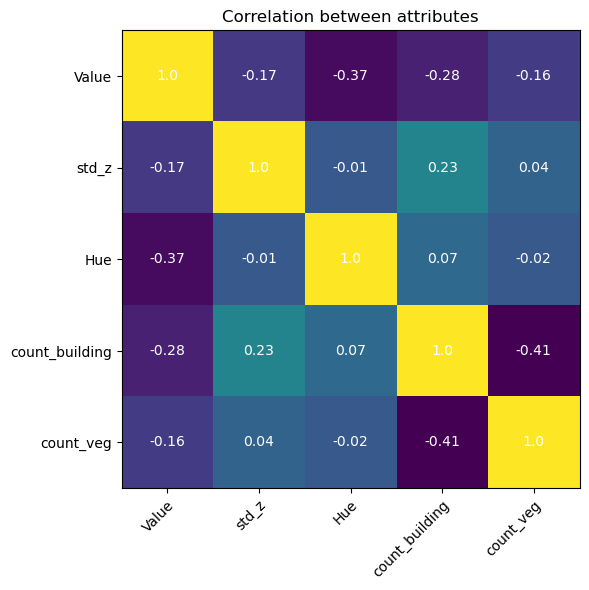

,Value,std_z,Hue,count_building,count_veg
5041654,0.539062,0.315237,0.333333,0,1
5041655,0.738281,0.395515,0.214286,0,25
5041656,0.703125,0.175067,0.229167,0,1
5041657,0.644531,0.156555,0.388889,0,0
5041658,0.644531,0.156257,0.388889,0,0
...,...,...,...,...,...
5092144,0.226562,1.860310,0.506173,43,26
5092145,0.207031,2.085327,0.487179,32,39
5092146,0.238281,1.719300,0.517241,46,23
5092147,0.226562,1.893988,0.505952,43,25


In [29]:
features = ['Value', 'std_z', 'Hue', 'count_building', 'count_veg']
sub_df = df_features.loc[:,features]
visualize_correlation(sub_df.corr(), 6)
sub_df

<b> ToDo: Check for NaN-Value, drop NaN-Values</b>

In [30]:
sub_df[sub_df.isna().any(axis=1)]

,Value,std_z,Hue,count_building,count_veg


## Implementation of K-Means

For the implementation of K-Means we will use the `Scikit-learn` Library.

For an easier clustering we do two different clustering. <br>
One for the points within the ALKIS-Classes `AX_Strassenverkehr`, `AX_Weg` und `AX_Platz`

In [31]:
# Get indices of the points inside of the road
ind_X_inside = df_features.loc[df_features.inside_road == 1].index

# X inside of road
X_inside = sub_df.loc[ind_X_inside, :].to_numpy()

X_inside

array([[ 0.5390625 ,  0.31523659,  0.33333333,  0.        ,  1.        ],
       [ 0.73828125,  0.39551541,  0.21428571,  0.        , 25.        ],
       [ 0.703125  ,  0.17506739,  0.22916667,  0.        ,  1.        ],
       ...,
       [ 0.21875   ,  1.34675855,  0.55172414, 28.        , 21.        ],
       [ 0.21484375,  1.35526857,  0.55357143, 39.        , 21.        ],
       [ 0.203125  ,  1.33211411,  0.5308642 , 30.        , 23.        ]])

In [32]:
# Get indices of the points inside of the road
ind_X_outside = df_features.loc[df_features.inside_road != 1].index

# X outside of road
X_outside = sub_df.loc[ind_X_outside,:].to_numpy()

X_outside

array([[ 0.671875  ,  0.9965133 ,  0.3125    ,  0.        , 38.        ],
       [ 0.73046875,  0.97163509,  0.25555556,  0.        , 48.        ],
       [ 0.82421875,  0.96958715,  0.21428571,  0.        , 42.        ],
       ...,
       [ 0.23828125,  1.71929966,  0.51724138, 46.        , 23.        ],
       [ 0.2265625 ,  1.89398789,  0.50595238, 43.        , 25.        ],
       [ 0.203125  ,  0.87531523,  0.56666667, 82.        ,  2.        ]])

### Scaling with MinMaxScaler
Scale the calculated values using the MinMaxScaler of the `Sci-Kit learn` library.<br>
Every Feature will be scaled in an intervall `[0:1]`

In [33]:
X_inside_scaled = MinMaxScaler().fit_transform(X_inside)
X_outside_scaled = MinMaxScaler().fit_transform(X_outside)

print('Shape of Feature Matrix outside road: ', X_outside_scaled.shape)
X_outside_scaled

Shape of Feature Matrix outside road:  (48125, 5)


array([[0.63888889, 0.18833169, 0.31344985, 0.        , 0.38383838],
       [0.70833333, 0.18344645, 0.25633232, 0.        , 0.48484848],
       [0.81944444, 0.1830443 , 0.21493704, 0.        , 0.42424242],
       ...,
       [0.125     , 0.33026242, 0.51881354, 0.46464646, 0.23232323],
       [0.11111111, 0.36456526, 0.50749023, 0.43434343, 0.25252525],
       [0.08333333, 0.16453249, 0.56838906, 0.82828283, 0.02020202]])

In [34]:
print('Shape of Feature Matrix inside road: ', X_inside_scaled.shape)
X_inside_scaled

Shape of Feature Matrix inside road:  (2370, 5)


array([[0.44660194, 0.03338309, 0.33846154, 0.        , 0.01010101],
       [0.69417476, 0.04470841, 0.21758242, 0.        , 0.25252525],
       [0.65048544, 0.01360875, 0.23269231, 0.        , 0.01010101],
       ...,
       [0.04854369, 0.1789048 , 0.5602122 , 0.34146341, 0.21212121],
       [0.04368932, 0.18010535, 0.56208791, 0.47560976, 0.21212121],
       [0.02912621, 0.17683884, 0.53903134, 0.36585366, 0.23232323]])

Choosing the right number of `K` may not be so obvious. We can use the <b>Elbow method</b> if we want some heuristic help.<br>
We will loop `K` over a range of `[1:20]`, execute our K-Means clustering with the `K` and compute a WCSS (Within-Cluster Sum of Square) value that we will store in a list

In [35]:
#Skip elbow method?
skip = True
wcss = []

if not skip:
    for i in tqdm(range(1, 20)):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X_outside_scaled)
        wcss.append(kmeans.inertia_)

Then, once out `wcss` list is complete, we can plot the graph with the calculated `wcss` value corresponding to the `K` value.

In [36]:
if not skip:
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    ax.plot(range(1, 20), wcss)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS') 

    plt.show()

As we can see in the plot above, 5 seems to be a suitable parameter<br>
Lets fit our Feature Vector again with `K=5` und save the labels.

### K-Means for outside of road

In [37]:
K = 8
kmeans_outside = KMeans(n_clusters = K, init = 'k-means++', random_state = 42)

In [38]:
kmeans_outside.fit(X_outside_scaled)

labels_outside = kmeans_outside.labels_
labels_outside

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([6, 6, 6, ..., 3, 3, 5], dtype=int32)

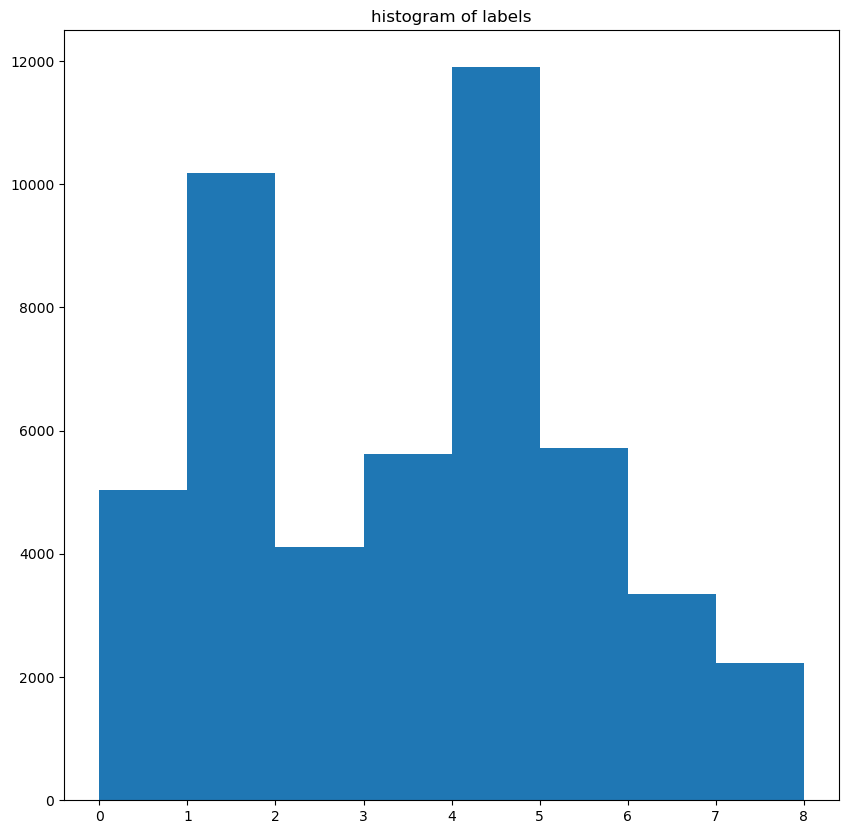

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.hist(labels_outside, bins = np.arange(0, K+1))
ax.set_title("histogram of labels")
ax.set_xticks(np.arange(0, K+1))
plt.show()

### K-Means for inside of road

In [40]:
K = 8
kmeans_inside = KMeans(n_clusters = K, init = 'k-means++', random_state = 42)

In [41]:
kmeans_inside.fit(X_inside_scaled)

labels_inside = kmeans_inside.labels_ + K
labels_inside

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 8, 14, 14, ..., 15, 15, 15], dtype=int32)

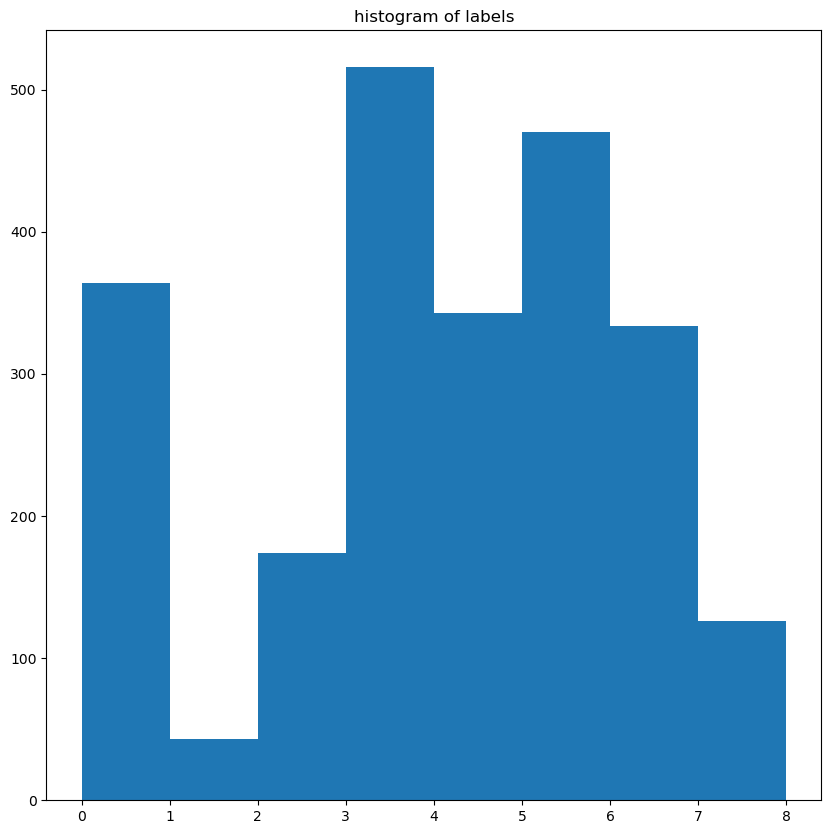

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.hist(labels_inside-K, bins = np.arange(0, K+1))
ax.set_title("histogram of labels")
ax.set_xticks(np.arange(0, K+1))
plt.show()

## Save Results

Merge label results with the corresponding indices.

### Add Results to DataFrame

In [43]:
df_features.loc[ind_X_inside, 'label'] = labels_inside
df_features.loc[ind_X_outside, 'label'] = labels_outside

df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground,label
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0,1,0,8.0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0,25,0,14.0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0,1,97,14.0
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0,0,98,8.0
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0,0,98,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,43,26,0,3.0
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,32,39,0,3.0
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,46,23,0,3.0
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,43,25,0,3.0


### Write new LAS-File
Following function will save a DataFrame to the input path.

In [44]:
def save_df_to_las(df, path):
    
    header = laspy.LasHeader(point_format=3, version="1.2")
    
    atts = []
    for dim in header.point_format.dimensions:
        atts.append(dim.name)
    
    for dim in df.columns:
        if dim not in atts:
            header.add_extra_dim(laspy.ExtraBytesParams(name=dim, type=np.float32))
    
    las_new = laspy.LasData(header)

    las_new.x = df.X.to_numpy()
    las_new.y = df.Y.to_numpy()
    las_new.z = df.Z.to_numpy()
    
    for col in df.loc[:,'intensity':].columns:
        las_new[col] = df[col].to_numpy()
    
    las_new.write(path)
    print('LAS file has been exported to ', path)

#### Export K-Means resutls
Define path, where the data will be stored

In [45]:
path

'../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/temp/'

In [46]:
ex_path = path.replace('temp/', file.replace('classified','')) + '/'
ex_path

'../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/'

Check if folder already exists. <br> If not, create a new one.

In [47]:
if not os.path.isdir(ex_path):
    os.makedirs(ex_path)
    print('created new folder', ex_path)
else:
    print(path, 'already exists')

created new folder ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/


Get the different labels

In [48]:
df_features.fillna(-1)
df_features

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground,label
5041654,554641.12,5799257.16,70.20,17515,6,0,99,35072,35328,35072,...,0.212617,0.763335,0.315237,0.539062,0.007246,0.333333,0,1,0,8.0
5041655,554634.82,5799249.42,71.11,7519,4,0,108,47872,48384,46592,...,0.474991,0.470362,0.395515,0.738281,0.037037,0.214286,0,25,0,14.0
5041656,554667.54,5799214.34,65.28,8281,1,0,98,45312,46080,44032,...,-10.012734,-47.962688,0.175067,0.703125,0.044444,0.229167,0,1,97,14.0
5041657,554590.56,5799353.39,64.66,9439,2,0,180,39936,42240,40704,...,0.909944,0.071863,0.156555,0.644531,0.054545,0.388889,0,0,98,8.0
5041658,554590.48,5799353.52,64.64,9439,2,0,180,39936,42240,40704,...,0.904521,0.077837,0.156257,0.644531,0.054545,0.388889,0,0,98,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092144,554982.39,5799987.93,71.28,11717,3,0,155,7936,14592,14848,...,-0.620606,-1.925857,1.860310,0.226562,0.465517,0.506173,43,26,0,3.0
5092145,554984.06,5799986.93,70.81,11720,2,0,150,6912,13568,13056,...,1.865099,-8.768333,2.085327,0.207031,0.490566,0.487179,32,39,0,3.0
5092146,554982.14,5799988.36,71.14,11716,4,0,178,8192,14848,15616,...,1.240034,-5.148298,1.719300,0.238281,0.475410,0.517241,46,23,0,3.0
5092147,554982.04,5799988.25,71.41,11715,4,0,174,7680,14592,14848,...,0.535804,0.322697,1.893988,0.226562,0.482759,0.505952,43,25,0,3.0


In [49]:
lst_inds = []
for i in df_features.index:
    if i not in ind_X_inside and i not in ind_X_outside:
        lst_inds.append(i)

print('Anzahl nicht in KMeans betrachtete Punkte:', len(lst_inds))
df_features.loc[lst_inds,:]

Anzahl nicht in KMeans betrachtete Punkte: 0


,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,Planarity,Linearity,std_z,Value,Saturation,Hue,count_building,count_veg,count_ground,label


In [50]:
df_features.loc[lst_inds, 'label'] = -1

In [51]:
labels = np.sort(df_features.label.unique())
labels

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

Export las-files for every different label.

In [52]:
for label in labels:
    label_df = df_features.loc[df_features.label == label]
    export_pc = (ex_path + 'label_' + str(label) + '.las').replace('.0','')
    save_df_to_las(label_df, export_pc)

print('Minimum:\n', label_df.loc[:, 'X':'Z'].min(axis=0))
print()
print('Maximum:\n', label_df.loc[:, 'X':'Z'].max(axis=0))

LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_0.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_1.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_2.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_3.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_4.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_5.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_6.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_7.las
LAS file has been exported to  ../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/554000_5799000.laz/label_8.las
LAS file h